In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lasso_path

In [2]:
file = r"C:\Users\zacwa\bike_sharing_daily.csv"
bikes = pd.read_csv(file,sep=',')

#### Column headers

https://www.kaggle.com/datasets/contactprad/bike-share-daily-data?resource=download

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
bikes['dteday'] = pd.to_datetime(bikes.dteday,format='%Y-%m-%d')

In [4]:
print(bikes.shape)
print(bikes.columns)
bikes.head()

(731, 16)
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
bikes_continuous = bikes[['temp','atemp','hum','windspeed','casual','registered','cnt']]
bikes_continuous.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Observations:
- atemp and temp are virtually perfectly correlated, can remove atemp
- humidity isn't correlated with useage, which is surprising
- windspeed is less correlated than I expected

<Axes: >

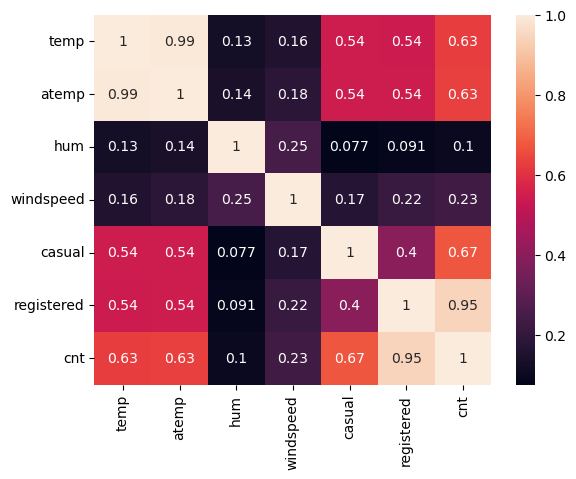

In [6]:
sns.heatmap(abs(bikes_continuous.corr()), annot = True)

First, it seems intuitive that temperature and humidity might impact user counts. There is no correlation between users and humidity. The registered users could be routine users (eg, working professionals and students) who commute using bikes. The casual users are tourists, weekenders, bar hoppers, etc. Both user counts correlate with temperature. There are some stray points creating a fan shape for casual users. I would speculate those high points correspond to a particular season, but they do not. They relate to fluctuation in summer and early fall.

There isn't a big visual difference between temp and atemp. The correlation between atemp and user count is very, very slightly higher than temp. I would have expected it to be higher, given the 'feels-like' temperature is the temperature that you perceive, and this may persuade or dissuade users. 

In [7]:
print(f'correlation of cnt users and temp: {np.corrcoef(bikes.temp,bikes.cnt,rowvar=False)[1,0]}')
print(f'correlation of registered users and temp: {np.corrcoef(bikes.temp,bikes.registered,rowvar=False)[1,0]}')
print(f'correlation of casual users and temp: {np.corrcoef(bikes.temp,bikes.casual,rowvar=False)[1,0]}')
print()
print(f'correlation of cnt users and atemp: {np.corrcoef(bikes.atemp,bikes.cnt,rowvar=False)[1,0]}')
print(f'correlation of registered users and atemp: {np.corrcoef(bikes.atemp,bikes.registered,rowvar=False)[1,0]}')
print(f'correlation of casual users and atemp: {np.corrcoef(bikes.atemp,bikes.casual,rowvar=False)[1,0]}')

correlation of cnt users and temp: 0.6274940090334918
correlation of registered users and temp: 0.5400119661617864
correlation of casual users and temp: 0.5432846616821875

correlation of cnt users and atemp: 0.631065699849181
correlation of registered users and atemp: 0.544191757638014
correlation of casual users and atemp: 0.5438636902622047


Quick observations:
- on work day median users is only slightly lower than on weekend/holidays; this is not what I expected; leisurely ridership looks very strong in DC
- seasonality impacts ridership significantly, which is intuitive and is complementary to the relationship between temperature and ridership, particularly because the further you go in the season in Spring, for instance, the higher the user rate and also the higher the temperature
- temperature appears at a glance to be increasing from year one to year two, including also the very beginning of Spring in the third year, but the seasons look really off....
- There is much more variance in weekend/holiday useage than on work days, which is intuitive; it would be interesting/important to know what would account for the variance in nonworkday useage

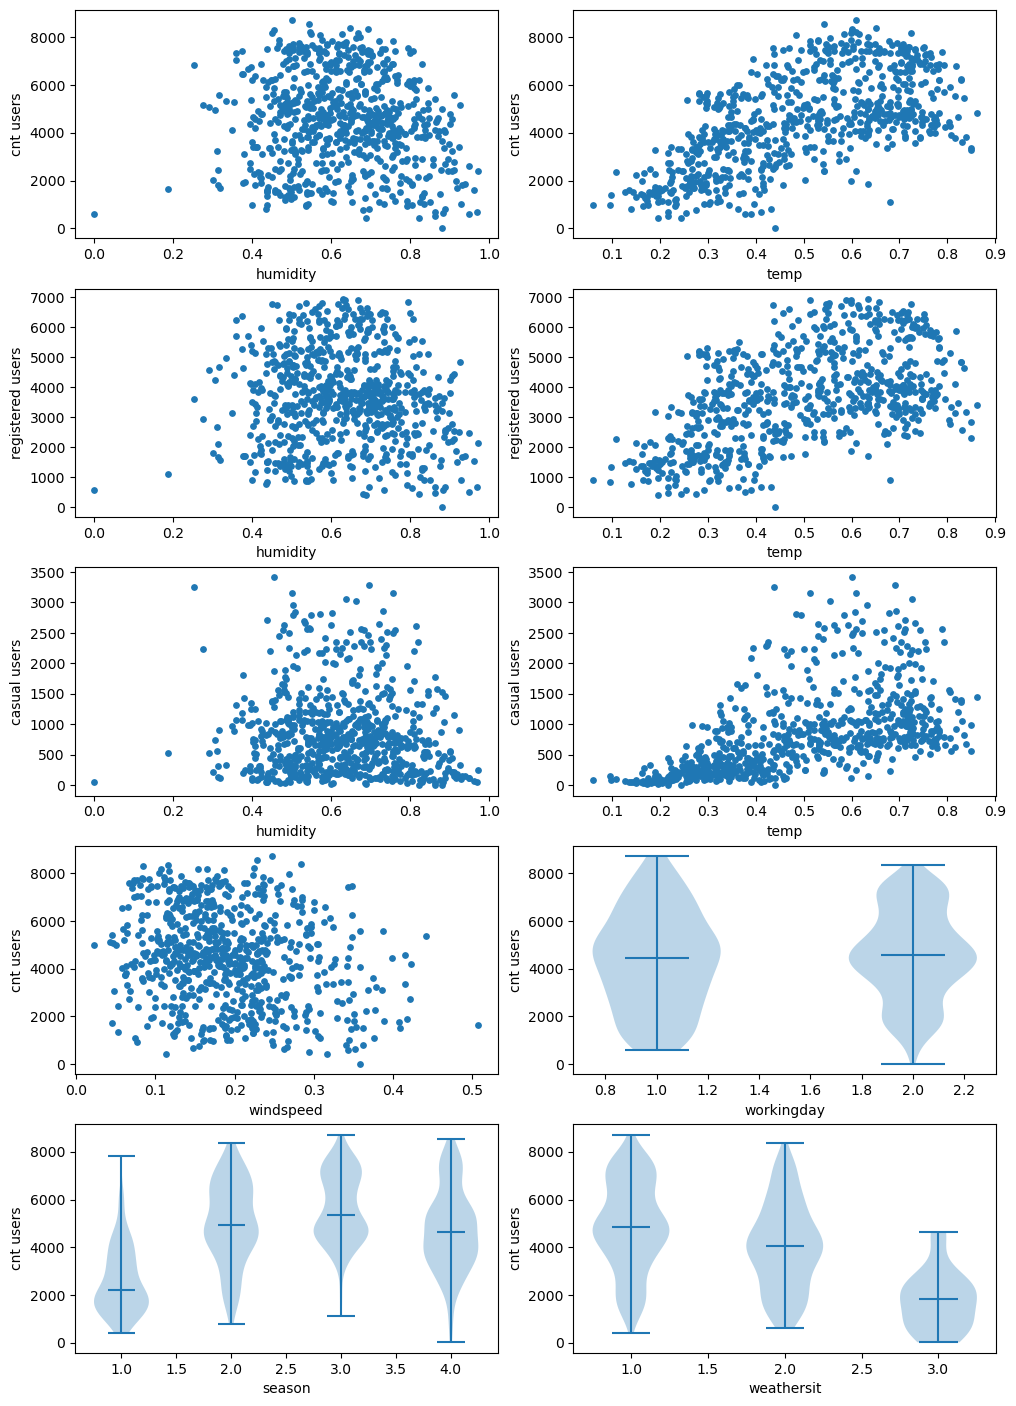

In [8]:
fig, axs = plt.subplots(5,2,figsize=(10,14))
axs = axs.flatten()
axs[0].scatter(bikes.hum,bikes.cnt,s=15)
axs[0].set_ylabel('cnt users')
axs[0].set_xlabel('humidity')
axs[1].scatter(bikes.temp,bikes.cnt,s=15)
axs[1].set_ylabel('cnt users')
axs[1].set_xlabel('temp')

axs[2].scatter(bikes.hum,bikes.registered,s=15)
axs[2].set_ylabel('registered users')
axs[2].set_xlabel('humidity')
axs[3].scatter(bikes.temp,bikes.registered,s=15)
axs[3].set_ylabel('registered users')
axs[3].set_xlabel('temp')

axs[4].scatter(bikes.hum,bikes.casual,s=15)
axs[4].set_ylabel('casual users')
axs[4].set_xlabel('humidity')
axs[5].scatter(bikes.temp,bikes.casual,s=15)
axs[5].set_ylabel('casual users')
axs[5].set_xlabel('temp')

axs[6].scatter(bikes.windspeed,bikes.cnt,s=15)
axs[6].set_ylabel('cnt users')
axs[6].set_xlabel('windspeed')
axs[7].violinplot([bikes.loc[bikes.workingday==0,'cnt'],
                   bikes.loc[bikes.workingday==1,'cnt']],
                                                vert=True,
                                                showmedians=True,
                                                showextrema=True)
axs[7].set_ylabel('cnt users')
axs[7].set_xlabel('workingday')

axs[8].violinplot([bikes.loc[bikes.season==1,'cnt'],
                   bikes.loc[bikes.season==2,'cnt'],
                   bikes.loc[bikes.season==3,'cnt'],
                   bikes.loc[bikes.season==4,'cnt']],
                                                vert=True,
                                                showmedians=True,
                                                showextrema=True)
axs[8].set_ylabel('cnt users')
axs[8].set_xlabel('season')

axs[9].violinplot([bikes.loc[bikes.weathersit==1,'cnt'],
                   bikes.loc[bikes.weathersit==2,'cnt'],
                   bikes.loc[bikes.weathersit==3,'cnt']],
                                                vert=True,
                                                showmedians=True,
                                                showextrema=True)
axs[9].set_ylabel('cnt users')
axs[9].set_xlabel('weathersit')

fig.tight_layout(pad=0.5)

There is high variance in users in the late summer (September).

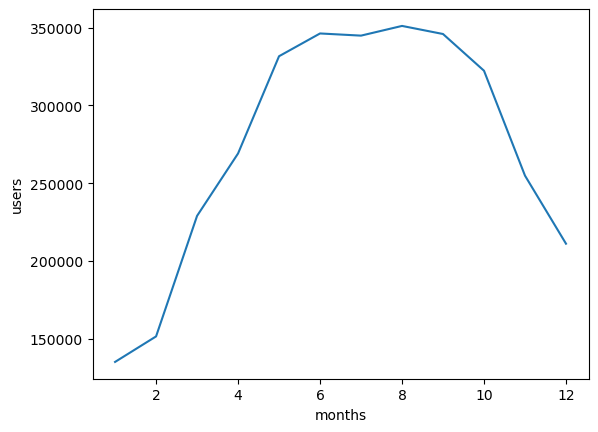

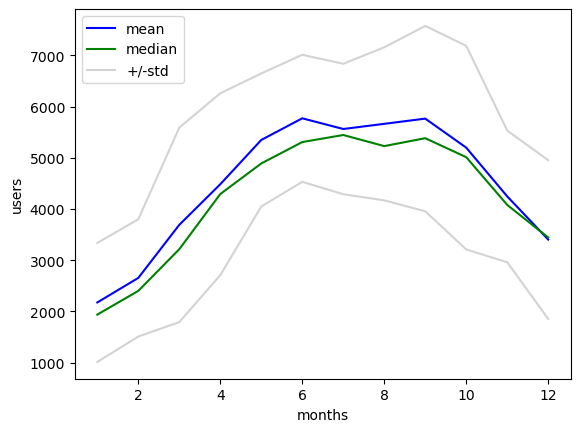

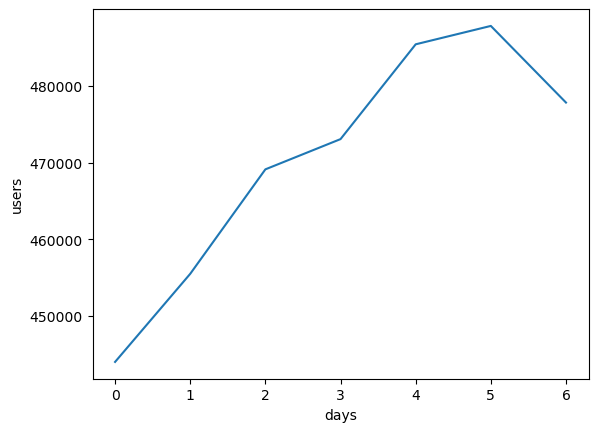

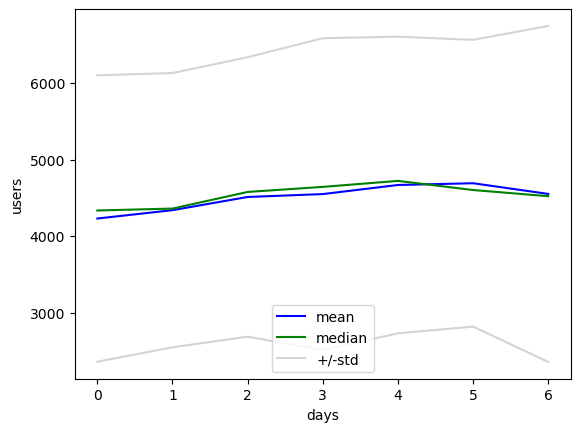

In [9]:
labels = ['months','days']
cols = ['mnth','weekday']
for lab, col in zip(labels,cols):
    monthlysum = bikes.groupby([col])['cnt'].sum()

    plt.figure()
    plt.plot(monthlysum)
    plt.xlabel(lab)
    plt.ylabel('users')
    plt.show()

    moavg = bikes.groupby([col])['cnt'].mean().reset_index().rename(columns={'cnt':'mean'})
    momed = bikes.groupby([col])['cnt'].median().reset_index().rename(columns={'cnt':'median'})
    mostd = bikes.groupby([col])['cnt'].std().reset_index().rename(columns={'cnt':'std'})

    mos = moavg.merge(momed.merge(mostd,how='inner'),how='inner')

    plt.figure()
    plt.plot(mos[col],mos['mean'],c='blue',label='mean')
    plt.plot(mos[col],mos['median'],c='green',label='median')
    plt.plot(mos[col],mos['mean'] + mos['std'],c='lightgray',label='+/-std')
    plt.plot(mos[col],mos['mean'] - mos['std'],c='lightgray')
    plt.legend()
    plt.xlabel(lab)
    plt.ylabel('users')
    plt.show()

The correlation between temperature and users is an intuitive finding. As the temperature increases towards the maximum users seem to slide downwards. There isn't a consistent correlation across seasons, however.

correlation of cnt users and temp: 0.6274940090334918


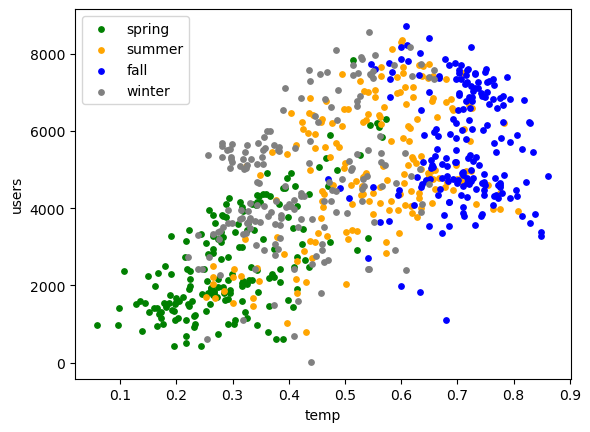

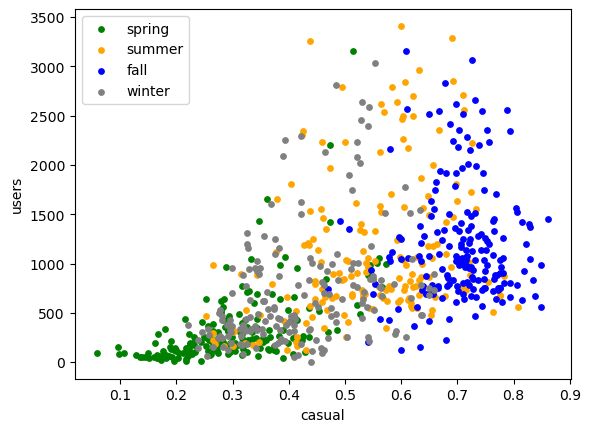

In [10]:
print(f'correlation of cnt users and temp: {np.corrcoef(bikes.temp,bikes.cnt,rowvar=False)[1,0]}')

season_code = bikes.season.unique().tolist()
season_code.sort()
seasons = ['spring','summer','fall','winter']
cs = ['green','orange','blue','gray']
for sc, s, c in zip(season_code,seasons,cs):
    temp = bikes.loc[bikes.season==sc,'temp'].copy()
    tusers = bikes.loc[bikes.season==sc,'cnt'].copy()
    plt.scatter(temp,tusers,c=c,label=s,s=15)
plt.xlabel('temp')
plt.ylabel('users')
plt.legend()
plt.show()

for sc, s, c in zip(season_code,seasons,cs):
    temp = bikes.loc[bikes.season==sc,'temp'].copy()
    tusers = bikes.loc[bikes.season==sc,'casual'].copy()
    plt.scatter(temp,tusers,c=c,label=s,s=15)
plt.xlabel('casual')
plt.ylabel('users')
plt.legend()
plt.show()

Both graphs (users vs date and temp vs date) have an upward trend. I'll model the data with regression to determine the magnitude and significance that temp has on users. 

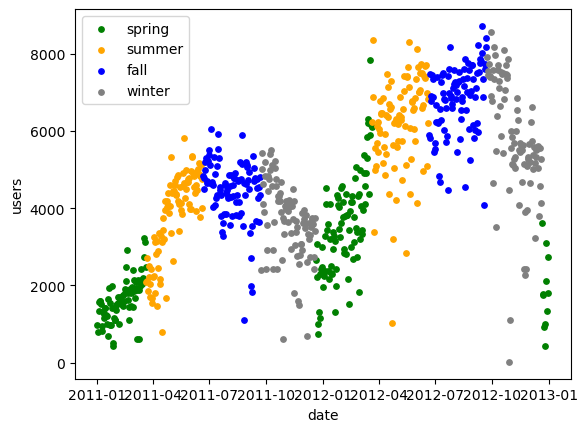

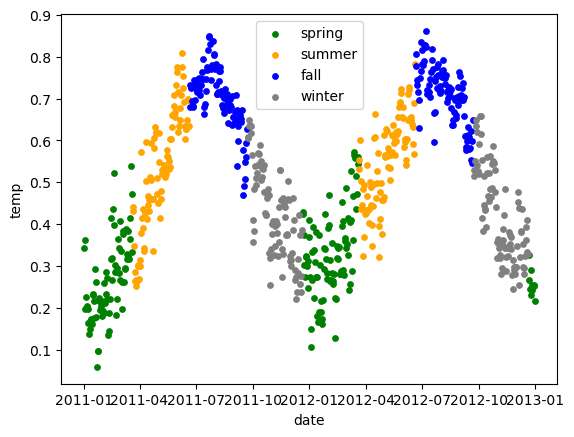

In [11]:
for sc, s, c in zip(season_code,seasons,cs):
    day = bikes.loc[bikes.season==sc, 'dteday'].copy()
    cnt = bikes.loc[bikes.season==sc, 'cnt'].copy()
    plt.scatter(day,cnt,c=c,label=s,s=15)
plt.legend()
plt.xlabel('date')
plt.ylabel('users')
plt.show()

for sc, s, c in zip(season_code,seasons,cs):
    day = bikes.loc[bikes.season==sc, 'dteday'].copy()
    temp = bikes.loc[bikes.season==sc, 'temp'].copy()
    plt.scatter(day,temp,c=c,label=s,s=15)
plt.legend()
plt.xlabel('date')
plt.ylabel('temp')
plt.show()

I'm surprised to see that temperatures peak in the fall. The fall period per dates that correspond to season = 3 look incorrect! A quick search revealed that fall began in late September in 2011. I don't want to change the data because I don't know how or why it came to look like this.... Also, Spring has lower temperatures than Winter. The date range for Spring also looks incorrect. Ordinarily, this issue would need to be investigated. But I'll ignore it, resisting the urge to adjust it, and press on.

In [12]:
start = np.min(bikes.loc[(bikes.season==3)&(bikes.yr==1),'dteday'])
end = np.max(bikes.loc[(bikes.season==3)&(bikes.yr==1),'dteday'])

print(f'beginning of fall {start}')
print(f'end of fall {end}')

beginning of fall 2012-06-21 00:00:00
end of fall 2012-09-22 00:00:00


I'm using .get_dummies() because it seemlessly keeps the categories as column headers. I want this for regression analysis.

In [13]:
Xc = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
X = pd.get_dummies(bikes[Xc],columns=['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit'])
X.head()

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3
0,0.344167,0.363625,0.805833,0.160446,985,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
1,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,0.196364,0.189405,0.437273,0.248309,1349,1,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
3,0.200000,0.212122,0.590435,0.160296,1562,1,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0
4,0.226957,0.229270,0.436957,0.186900,1600,1,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0


The residual plots indicate that there is no problem with heteroskedasticity. No transformations or other considerations are needed, I believe. 

training mse 590309.6963387344
test mse 515994.4483461846


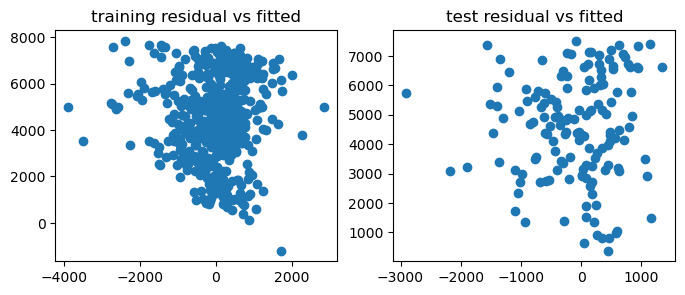

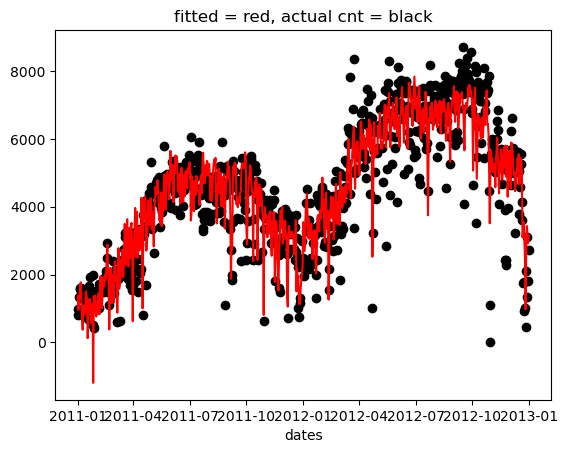

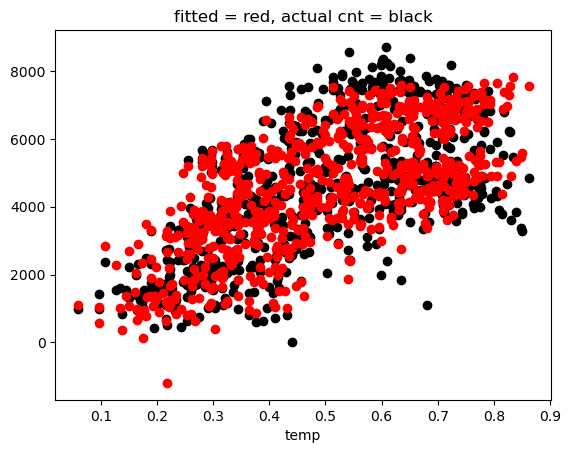

In [14]:
exclude = ['atemp','cnt']
tr_c = X.columns[~X.columns.isin(exclude)]
X_ = sm.add_constant(X[tr_c]) # add intercept

xtrain,xtest,ytrain,ytest = train_test_split(X_,X['cnt'],
                                            test_size=0.2,
                                            random_state=69,
                                            shuffle=True)
ols = sm.OLS(ytrain,xtrain)
model = ols.fit()
y_hat_train = model.predict(xtrain)
y_hat_test = model.predict(xtest)
y_hat_plot = model.predict(X_)

residuals_train = ytrain-y_hat_train
residuals_test = ytest-y_hat_test

print(f'training mse {np.mean((residuals_train)**2)}')
print(f'test mse {np.mean((residuals_test)**2)}')

fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].scatter(residuals_train,y_hat_train)
ax[0].set_title('training residual vs fitted')
ax[1].scatter(residuals_test,y_hat_test)
ax[1].set_title('test residual vs fitted')
plt.show()

plt.figure()
plt.scatter(bikes.dteday,bikes.cnt,c='black')
plt.plot(bikes.dteday,y_hat_plot,c='red')
plt.title('fitted = red, actual cnt = black')
plt.xlabel('dates')
plt.show()

plt.figure()
plt.scatter(bikes.temp,bikes.cnt,c='black')
plt.scatter(bikes.temp,y_hat_plot,c='red')
plt.title('fitted = red, actual cnt = black')
plt.xlabel('temp')
plt.show()

Unsurprisingly, temp is highly significant. 

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     110.2
Date:                Sat, 17 Jun 2023   Prob (F-statistic):          1.89e-203
Time:                        17:00:45   Log-Likelihood:                -4708.9
No. Observations:                 584   AIC:                             9474.
Df Residuals:                     556   BIC:                             9596.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          943.1902    103.849      9.082      0.000     739.207    1147.174
temp          4542.1606    470.361      9.657      0.000    3618.258    5466.063
hum          -1694.7432    348.587     -4.862      0.000   -2379.451   -1010.036
windspeed    -3298.6665    470.238     -7.015      0.000   -4222.326   -2375.007
season_1      -518.5023    135.707     -3.821      0.000    -785.064    -251.940
season_2       347.1839    136.239      2.548      0.011      79.578     614.790
season_3       231.4719    146.487      1.580      0.115     -56.263     519.207
season_4       883.0367    143.399      6.158      0.000     601.367    1164.706
yr_0          -526.8177     62.077     -8.486      0.000    -648.753    -404.883
yr_1          1470.0079     61.313     23.975      0.000    1349.574    1590.441
mnth_1        -358.0359    202.302     -1.770      0.077    -755.406      39.334
mnth_2        -188.5587    184.582     -1.022      0.307    -551.123     174.005
mnth_3         236.7841    143.900      1.645      0.100     -45.871     519.439
mnth_4         181.1302    174.868      1.036      0.301    -162.353     524.613
mnth_5         380.9791    185.342      2.056      0.040      16.923     745.035
mnth_6         222.1513    174.026      1.277      0.202    -119.677     563.979
mnth_7        -165.1748    206.750     -0.799      0.425    -571.282     240.932
mnth_8         136.8156    198.121      0.691      0.490    -252.341     525.972
mnth_9         783.8003    157.965      4.962      0.000     473.518    1094.082
mnth_10        278.9259    177.511      1.571      0.117     -69.748     627.600
mnth_11       -272.6704    190.577     -1.431      0.153    -647.010     101.669
mnth_12       -292.9567    164.646     -1.779      0.076    -616.360      30.447
holiday_0      766.4629     86.011      8.911      0.000     597.516     935.409
holiday_1      176.7273    100.894      1.752      0.080     -21.453     374.908
weekday_0      -80.6144     68.673     -1.174      0.241    -215.505      54.277
weekday_1       75.6875     80.501      0.940      0.348     -82.437     233.812
weekday_2       95.1946     83.034      1.146      0.252     -67.904     258.293
weekday_3      171.5908     84.023      2.042      0.042       6.550     336.632
weekday_4      141.6582     84.382      1.679      0.094     -24.088     307.404
weekday_5      223.5411     82.119      2.722      0.007      62.240     384.842
weekday_6      316.1324     69.650      4.539      0.000     179.324     452.941
workingday_0   412.2454     69.418      5.939      0.000     275.891     548.599
workingday_1   530.9449     51.960     10.218      0.000     428.882     633.007
weathersit_1  1036.5097     80.675     12.848      0.000     878.044    1194.975
weathersit_2   669.7662     76.718      8.730      0.000     519.073     820.459
weath

Given that there are many variables that aren't significant, I'll perform LASSO to see what is removed.

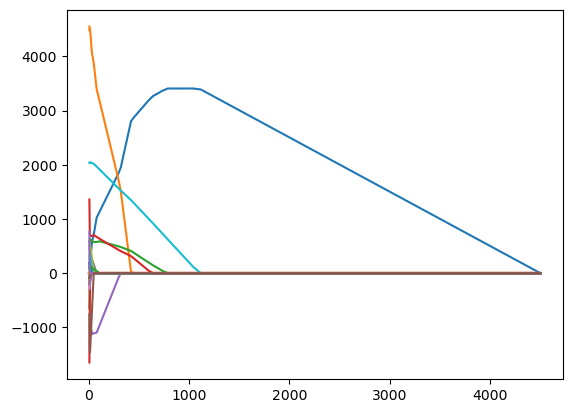

In [16]:
alphas, coefs, _ = lasso_path(X_,X['cnt'],n_alphas=100)

for coef in coefs:
    plt.plot(alphas,coef)

plt.show()

In [17]:
coefbin = coefs>0
nonzeros_for_alpha = np.sum(coefbin,axis=1)
nonzeros_for_alpha 
# count of which each variable is not zero for 100 alphas

array([100,  66,   0,   0,   0,  29,   0,  41,   0,  79,   0,   0,  20,
         0,  20,  13,   0,   0,  36,  31,   0,   0,  74,   0,   0,   0,
         0,   2,  14,  24,  28,   0,  46,  71,  13,   0])

These are the top 6 variables kept by LASSO, ie, these matter in predicting useage.

In [18]:
nonzero_sort_idx = nonzeros_for_alpha.argsort()
X_.columns[nonzero_sort_idx][-6:].tolist()

['workingday_1', 'temp', 'weathersit_1', 'holiday_0', 'yr_1', 'const']